In [3]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import plotly.graph_objects as go
from scipy.stats import gaussian_kde


### Import and Preprocess Data

In [ ]:
# Import dataframes with calibrated implied volatilities for each approximator
with open("mapping and calibration/files/calibrated_chunks_hagan.pkl", "rb") as f:
    chunks_hagan = pickle.load(f)
with open("mapping and calibration/files/calibrated_chunks_antonov.pkl", "rb") as f:
    chunks_antonov = pickle.load(f)
with open("mapping and calibration/files/calibrated_chunks_nn.pkl", "rb") as f:
    chunks_nn = pickle.load(f)

In [5]:
# Retrieve SABR parameters from dictionary
for approximator, chunks in {"hagan": chunks_hagan, "antonov": chunks_antonov, "nn": chunks_nn}.items():
    for _, df in enumerate(chunks):
        df[f"alpha_{approximator}"] = df[f"params_{approximator}"].apply(lambda x: x["alpha"])
        df[f"rho_{approximator}"] = df[f"params_{approximator}"].apply(lambda x: x["rho"])
        df[f"nu_{approximator}"] = df[f"params_{approximator}"].apply(lambda x: x["v"])

In [6]:
# Combine dataframes of all lists
combined_chunks = [
    pd.concat([h, a, n], axis=1).loc[:, ~pd.concat([h, a, n], axis=1).columns.duplicated()]
    for h, a, n in zip(chunks_hagan, chunks_antonov, chunks_nn)
]

df = pd.concat(combined_chunks, ignore_index=True)

### Calculate Errors

In [7]:
df["moneyness"] = df["strike_price"] / df["forward_price"]
df = df.dropna().reset_index(drop=True)
df['error_nn'] = np.abs((df['impl_volatility_nn'] - df['impl_volatility']) / df['impl_volatility']) * 100
df['error_antonov'] = np.abs((df['impl_volatility_antonov'] - df['impl_volatility']) / df['impl_volatility']) * 100
df['error_hagan'] = np.abs((df['impl_volatility_hagan'] - df['impl_volatility']) / df['impl_volatility']) * 100

### Median Calibration Error

In [8]:
print(np.median(df['error_nn']))
print(np.median(df['error_antonov']))
print(np.median(df['error_hagan']))

1.1112394801544296
1.6367194500754703
1.8005469806568322


/var/folders/x2/wtthh7_97c7c3r0cyqd569zc0000gn/T/ipykernel_17482/3113050040.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['T_bin', 'strike_bin'])[col].median().unstack()
/var/folders/x2/wtthh7_97c7c3r0cyqd569zc0000gn/T/ipykernel_17482/3113050040.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['T_bin', 'strike_bin'])[col].median().unstack()
/var/folders/x2/wtthh7_97c7c3r0cyqd569zc0000gn/T/ipykernel_17482/3113050040.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fal

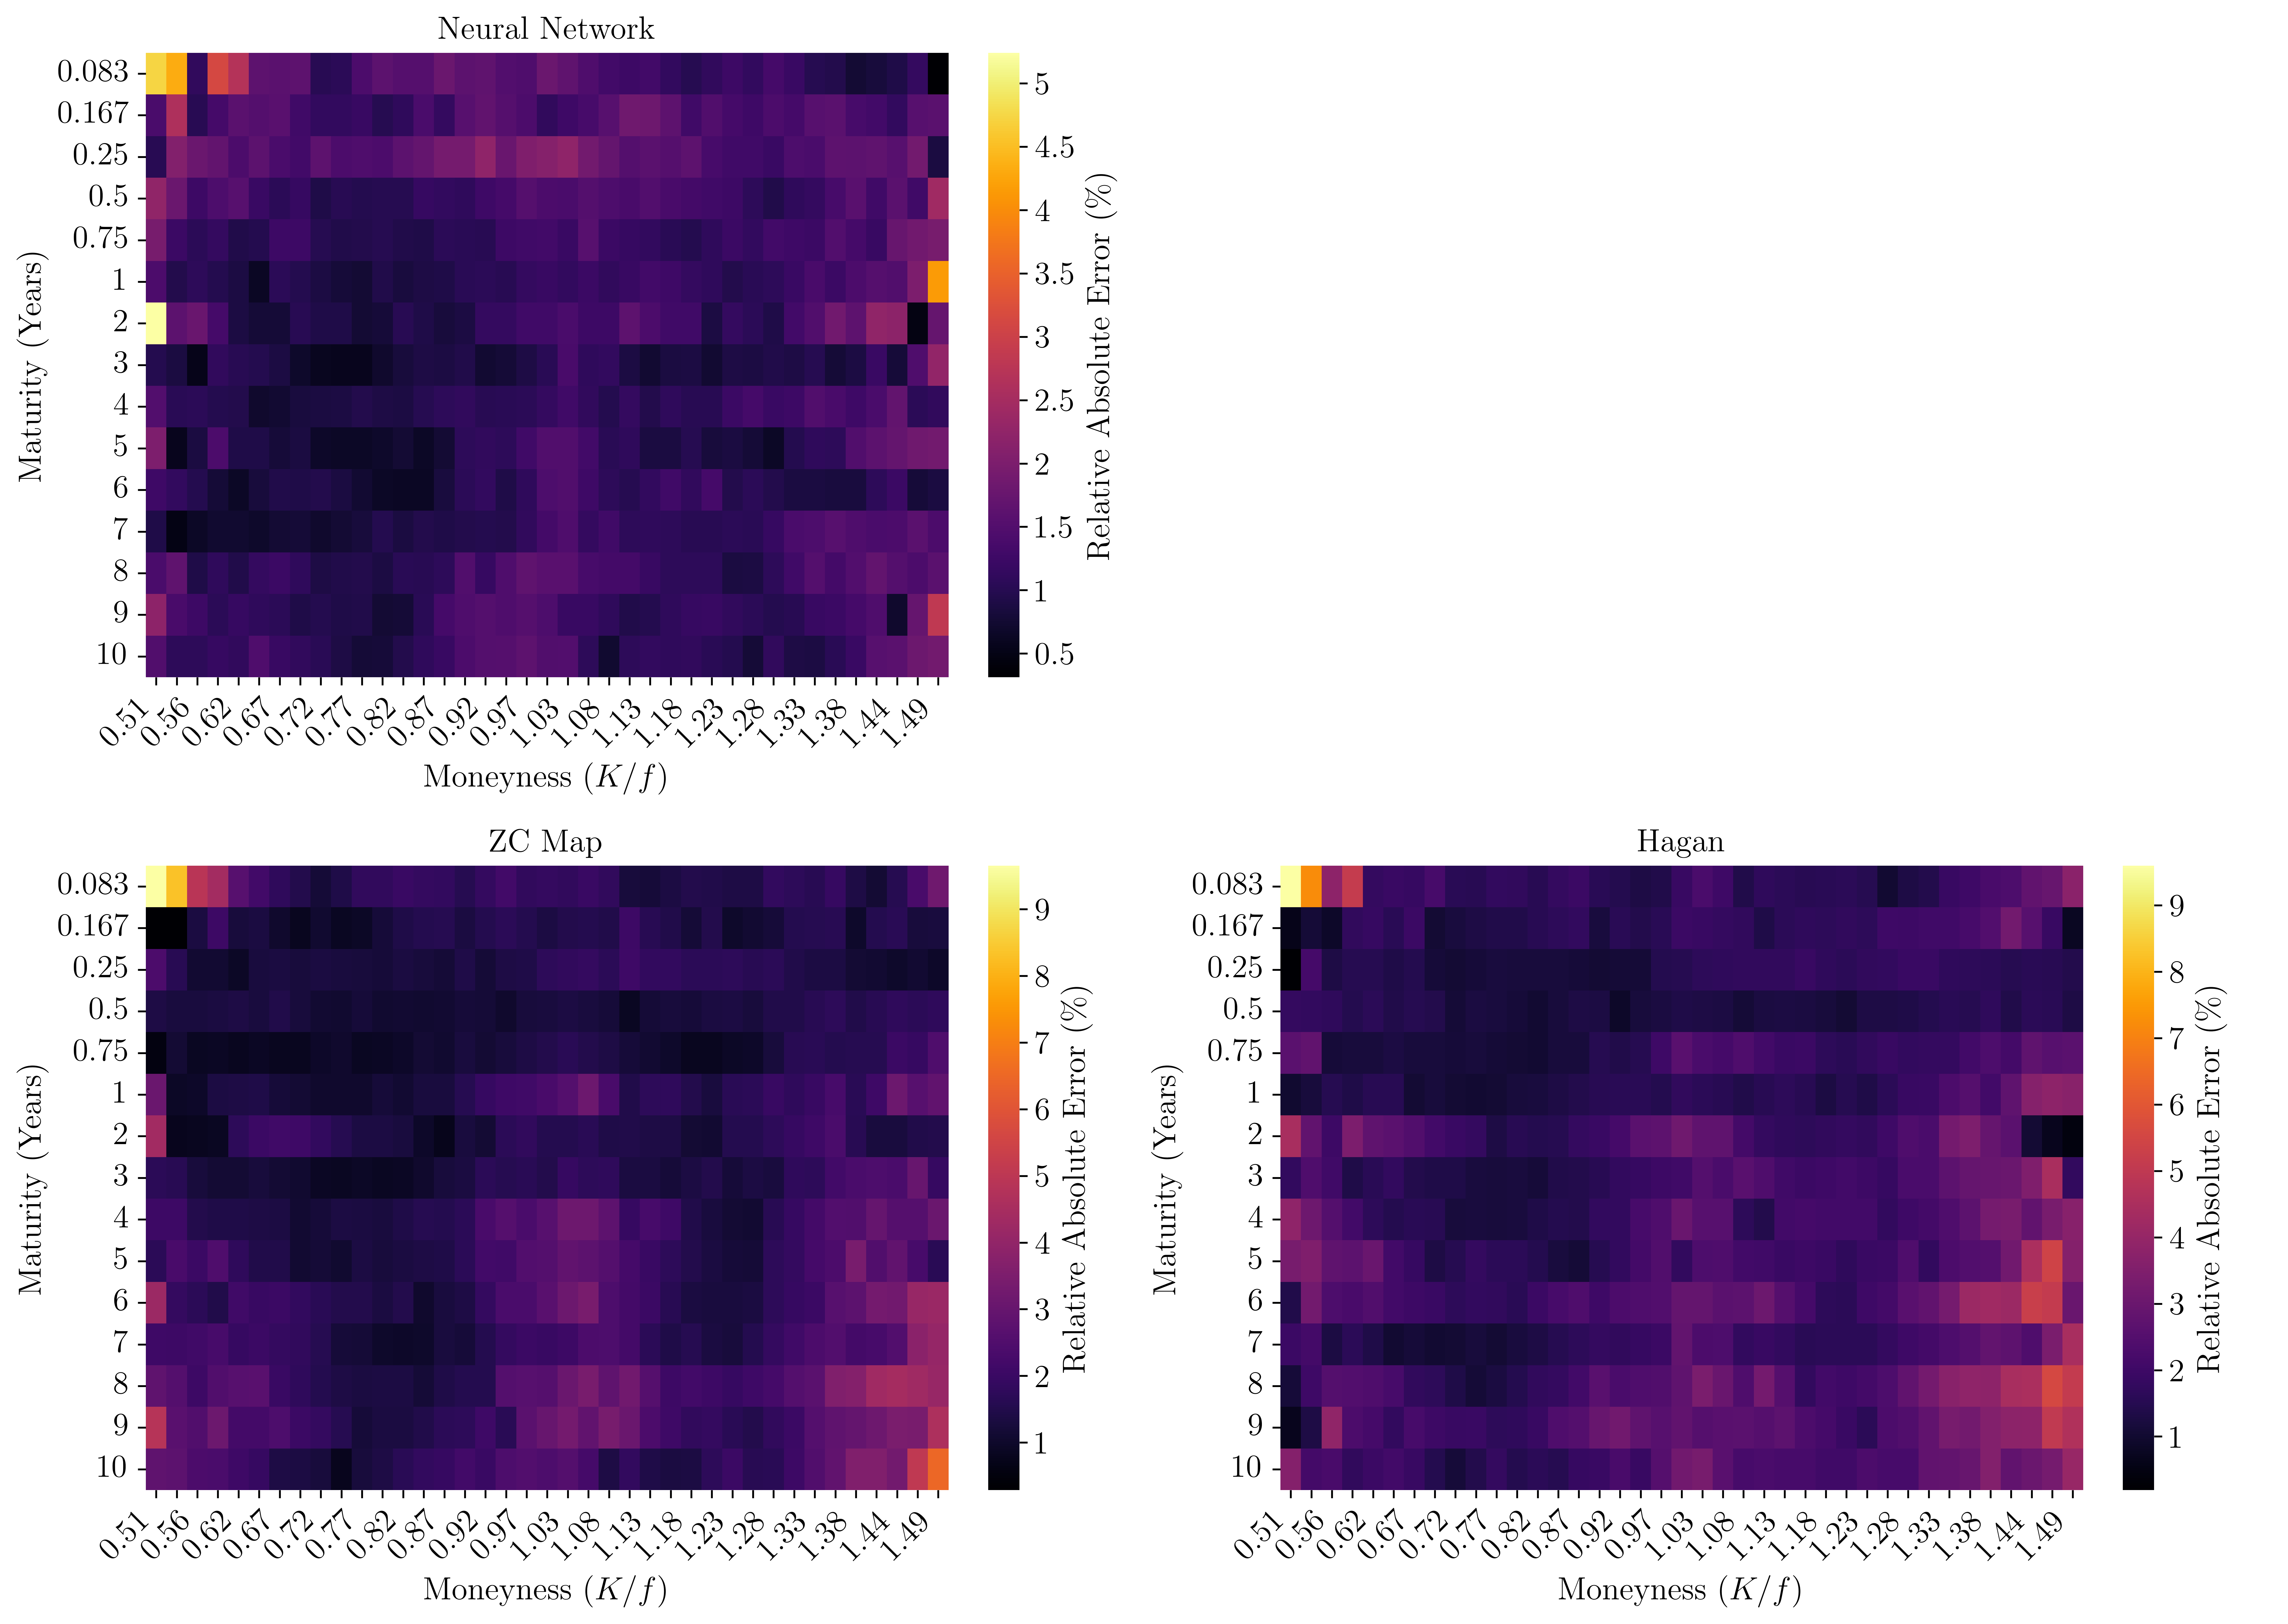

In [9]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Latin Modern Roman'],
    'font.size': 14,
    'font.weight': 'bold',
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'legend.title_fontsize': 14,
    'text.usetex': True,
})

unique_T = sorted(df['T'].unique())
strike_bins = np.linspace(df['moneyness'].min(), df['moneyness'].max(), 40)
df['strike_bin'] = pd.cut(df['moneyness'], bins=strike_bins)
df['T_bin'] = pd.Categorical(df['T'], categories=unique_T, ordered=True)

error_cols = ['error_nn', 'error_antonov', 'error_hagan']
titles = ['Neural Network', 'ZC Map', 'Hagan']

custom_ticks_dict = {
    "Neural Network": [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],
    "ZC Map": [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "Hagan": [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

fig = plt.figure(figsize=(14, 10), dpi=600)
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1])

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1])
]

fig.add_subplot(gs[0, 1]).axis("off")

for ax, col, title in zip(axes, error_cols, titles):
    grouped = df.groupby(['T_bin', 'strike_bin'])[col].median().unstack()
    Z = grouped.values
    Z = np.where(Z <= 0, np.nan, Z)

    T_labels = [("{:.3f}".format(float(t))).rstrip('0').rstrip('.') for t in grouped.index]
    strike_labels = [round(interval.mid, 2) for interval in grouped.columns]
    strike_labels = [lbl if i % 2 == 0 else "" for i, lbl in enumerate(strike_labels)]

    vmin = np.nanmin(Z)
    vmax = np.nanmax(Z)

    heatmap = sns.heatmap(
        Z, ax=ax, cmap="inferno", cbar=True,
        xticklabels=strike_labels, yticklabels=T_labels,
        vmin=vmin, vmax=vmax,
        cbar_kws={"pad": 0.04}
    )

    ax.tick_params(labelleft=True)
    cbar = heatmap.collections[0].colorbar
    custom_ticks = custom_ticks_dict[title]
    formatted_ticks = [f"{t:.2f}".rstrip('0').rstrip('.') for t in custom_ticks]
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels(formatted_ticks)
    cbar.set_label(r"Relative Absolute Error (\%)")

    ax.set_title(title)
    ax.set_xlabel("Moneyness ($K/f$)")
    ax.set_ylabel("Maturity (Years)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()

### Maximum Calibration Error

/var/folders/x2/wtthh7_97c7c3r0cyqd569zc0000gn/T/ipykernel_17482/1340176073.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['T_bin', 'strike_bin'])[col].max().unstack()
/var/folders/x2/wtthh7_97c7c3r0cyqd569zc0000gn/T/ipykernel_17482/1340176073.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['T_bin', 'strike_bin'])[col].max().unstack()
/var/folders/x2/wtthh7_97c7c3r0cyqd569zc0000gn/T/ipykernel_17482/1340176073.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to 

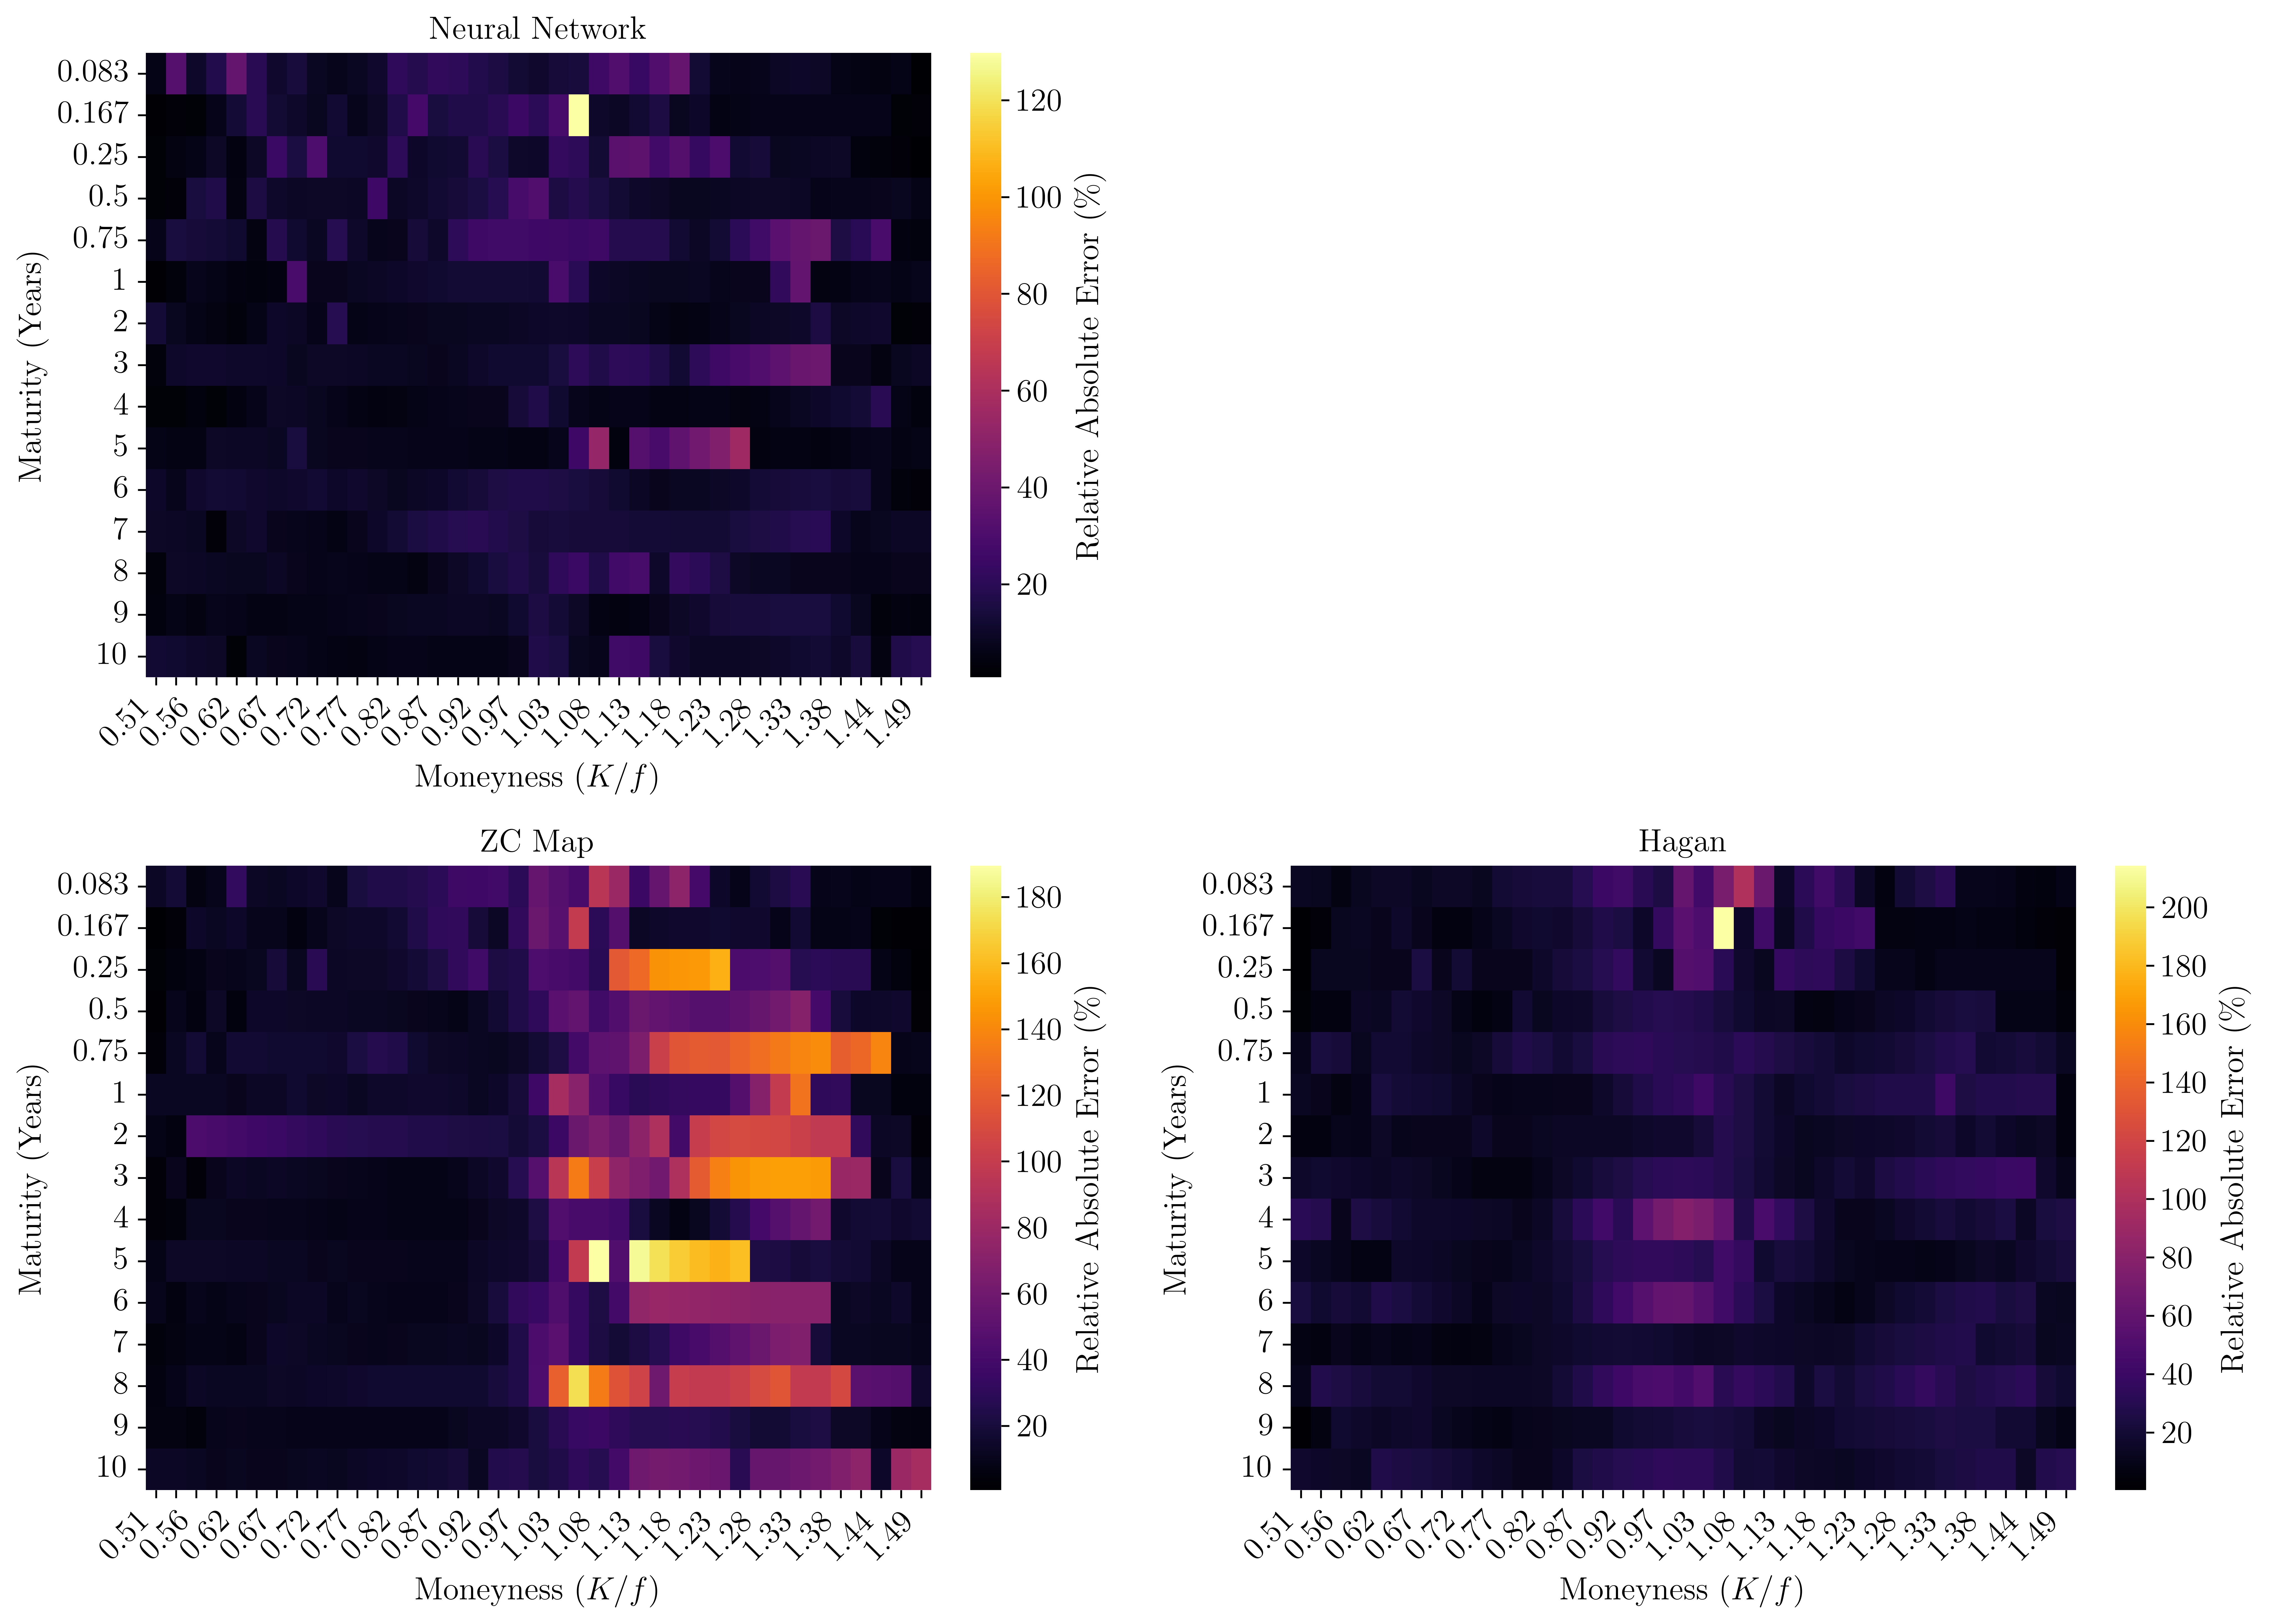

In [10]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Latin Modern Roman'],
    'font.size': 14,
    'font.weight': 'bold',
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 14,
    'axes.labelweight': 'bold',
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'legend.title_fontsize': 14,
    'text.usetex': True,
})

unique_T = sorted(df['T'].unique())
strike_bins = np.linspace(df['moneyness'].min(), df['moneyness'].max(), 40)
df['strike_bin'] = pd.cut(df['moneyness'], bins=strike_bins)
df['T_bin'] = pd.Categorical(df['T'], categories=unique_T, ordered=True)

error_cols = ['error_nn', 'error_antonov', 'error_hagan']
titles = ['Neural Network', 'ZC Map', 'Hagan']

custom_ticks_dict = {
    "Neural Network": [20, 40 ,60, 80, 100, 120],
    "ZC Map": [20, 40 ,60, 80, 100, 120, 140, 160, 180],
    "Hagan": [20, 40 ,60, 80, 100, 120, 140, 160, 180, 200]
}

fig = plt.figure(figsize=(14, 10), dpi=600)
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1], width_ratios=[1, 1])

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1])
]

fig.add_subplot(gs[0, 1]).axis("off")

for ax, col, title in zip(axes, error_cols, titles):
    grouped = df.groupby(['T_bin', 'strike_bin'])[col].max().unstack()
    Z = grouped.values
    Z = np.where(Z <= 0, np.nan, Z)

    T_labels = [("{:.3f}".format(float(t))).rstrip('0').rstrip('.') for t in grouped.index]
    strike_labels = [round(interval.mid, 2) for interval in grouped.columns]
    strike_labels = [lbl if i % 2 == 0 else "" for i, lbl in enumerate(strike_labels)]

    vmin = np.nanmin(Z)
    vmax = np.nanmax(Z)

    heatmap = sns.heatmap(
        Z, ax=ax, cmap="inferno", cbar=True,
        xticklabels=strike_labels, yticklabels=T_labels,
        vmin=vmin, vmax=vmax,
        cbar_kws={"pad": 0.04}
    )

    ax.tick_params(labelleft=True)
    cbar = heatmap.collections[0].colorbar
    custom_ticks = custom_ticks_dict[title]
    formatted_ticks = [f"{t:.2f}".rstrip('0').rstrip('.') for t in custom_ticks]
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels(formatted_ticks)
    cbar.set_label(r"Relative Absolute Error (\%)")

    ax.set_title(title)
    ax.set_xlabel("Moneyness ($K/f$)")
    ax.set_ylabel("Maturity (Years)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha="right")

plt.tight_layout()
plt.show()

### Parameter Errors

In [11]:
methods = ["hagan", "antonov", "nn"]
params = ["alpha", "rho", "nu"]

abs_err_table = {}

for method in methods:
    for param in params:
        col_true = f"{param}" 
        col_method = f"{param}_{method}"
        df[f"{param}_{method}_error"] = (df[col_method] - df[col_true])

abs_err_table = {}

for method in methods:
    abs_err_table[method] = {}
    for param in params:
        abs_err = np.abs(df[f"{param}_{method}_error"]).median()
        abs_err_table[method][param] = abs_err

pd.DataFrame(abs_err_table)


,hagan,antonov,nn
alpha,0.004238,0.003106,0.002150
rho,0.073154,0.087255,0.033388
nu,0.559567,0.281209,0.176964


In [12]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Latin Modern Roman'],
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'text.usetex': True,
    'axes.linewidth': 0.8,
})

base_cmap = plt.cm.inferno
fixed_colors = base_cmap(np.linspace(0, 0.78, 3))

color_map = {
    'nn': fixed_colors[0],
    'antonov': fixed_colors[1],
    'hagan': fixed_colors[2],
}

legend_names = {
    'nn': r'Neural Network',
    'antonov': r'ZC Map',
    'hagan': r'Hagan',
}

groups = {
    "Alpha": ['alpha_nn_error', 'alpha_antonov_error', 'alpha_hagan_error'],
    "Rho":   ['rho_nn_error',   'rho_antonov_error',   'rho_hagan_error'],
    "Nu":    ['nu_nn_error',    'nu_antonov_error',    'nu_hagan_error'],
}

plot_order_suffix = ['nn', 'antonov', 'hagan']

fig, axes = plt.subplots(3, 1, figsize=(12, 14), dpi=700, sharex=False)

for ax, (title, cols) in zip(axes, groups.items()):
    df_clean = df.copy()
    for c in cols:
        Q1 = df[c].quantile(0.05)
        Q3 = df[c].quantile(0.95)
        IQR = Q3 - Q1
        df_clean[c] = df[c].where(df[c].between(Q1 - IQR, Q3 + IQR))

    all_data = np.concatenate([df_clean[c].dropna().to_numpy() for c in cols])
    bin_edges = np.histogram_bin_edges(all_data, bins=60)

    for suffix in plot_order_suffix:
        col = next(x for x in cols if suffix in x)
        data = df_clean[col].dropna()

        ax.hist(data, bins=bin_edges, alpha=0.33,
                color=color_map[suffix], edgecolor='black',
                linewidth=0.25)

        ax.hist(data, bins=bin_edges, histtype='step',
                linewidth=1.4, color=color_map[suffix],
                label=legend_names[suffix])

    ax.set_title(title, pad=10)
    ax.set_ylabel(r'Observations', labelpad=4)
    ax.set_xlabel(r'Error', labelpad=6)
    ax.grid(True, linestyle='--', linewidth=0.55, alpha=0.55)
    ax.set_xlim(all_data.min()*1.02, all_data.max()*1.02)

    if ax is axes[0]:
        ax.legend(frameon=False, loc='upper right')

plt.tight_layout()
plt.show()